<a href="https://colab.research.google.com/github/raihankemmy/pyspark-titanic-classification/blob/main/PySpark_Big_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np
import pandas as pd
from pyspark.sql import *
from pyspark.sql.functions import *
from pyspark.ml.feature import *
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

In [ ]:
spark = SparkSession.builder.getOrCreate()
spark

# Load Data

In [ ]:
df = spark.read.csv('/content/drive/MyDrive/Colab Notebooks/dataset/titanic.csv',
                    header=True,
                    inferSchema=True,
                    nullValue='NA')

In [ ]:
df.show(5)

+-----------+--------+------+--------------------+------+----+-----+-----+----------------+-------+-----+--------+
|PassengerId|Survived|Pclass|                Name|   Sex| Age|SibSp|Parch|          Ticket|   Fare|Cabin|Embarked|
+-----------+--------+------+--------------------+------+----+-----+-----+----------------+-------+-----+--------+
|          1|       0|     3|Braund, Mr. Owen ...|  male|22.0|    1|    0|       A/5 21171|   7.25| null|       S|
|          2|       1|     1|Cumings, Mrs. Joh...|female|38.0|    1|    0|        PC 17599|71.2833|  C85|       C|
|          3|       1|     3|Heikkinen, Miss. ...|female|26.0|    0|    0|STON/O2. 3101282|  7.925| null|       S|
|          4|       1|     1|Futrelle, Mrs. Ja...|female|35.0|    1|    0|          113803|   53.1| C123|       S|
|          5|       0|     3|Allen, Mr. Willia...|  male|35.0|    0|    0|          373450|   8.05| null|       S|
+-----------+--------+------+--------------------+------+----+-----+-----+------

In [ ]:
df.columns

['PassengerId',
 'Survived',
 'Pclass',
 'Name',
 'Sex',
 'Age',
 'SibSp',
 'Parch',
 'Ticket',
 'Fare',
 'Cabin',
 'Embarked']

# Besaran Data

In [ ]:
print("The data contain %d records." % df.count())

The data contain 891 records.


# Tipe Data

In [ ]:
df.printSchema()

root
 |-- PassengerId: integer (nullable = true)
 |-- Survived: integer (nullable = true)
 |-- Pclass: integer (nullable = true)
 |-- Name: string (nullable = true)
 |-- Sex: string (nullable = true)
 |-- Age: double (nullable = true)
 |-- SibSp: integer (nullable = true)
 |-- Parch: integer (nullable = true)
 |-- Ticket: string (nullable = true)
 |-- Fare: double (nullable = true)
 |-- Cabin: string (nullable = true)
 |-- Embarked: string (nullable = true)



# Data Preparation

In [ ]:
df.show()

+-----------+--------+------+--------------------+------+----+-----+-----+----------------+-------+-----+--------+
|PassengerId|Survived|Pclass|                Name|   Sex| Age|SibSp|Parch|          Ticket|   Fare|Cabin|Embarked|
+-----------+--------+------+--------------------+------+----+-----+-----+----------------+-------+-----+--------+
|          1|       0|     3|Braund, Mr. Owen ...|  male|22.0|    1|    0|       A/5 21171|   7.25| null|       S|
|          2|       1|     1|Cumings, Mrs. Joh...|female|38.0|    1|    0|        PC 17599|71.2833|  C85|       C|
|          3|       1|     3|Heikkinen, Miss. ...|female|26.0|    0|    0|STON/O2. 3101282|  7.925| null|       S|
|          4|       1|     1|Futrelle, Mrs. Ja...|female|35.0|    1|    0|          113803|   53.1| C123|       S|
|          5|       0|     3|Allen, Mr. Willia...|  male|35.0|    0|    0|          373450|   8.05| null|       S|
|          6|       0|     3|    Moran, Mr. James|  male|null|    0|    0|      

In [ ]:
df = df.drop("Name")
df = df.drop("Age")
df = df.drop("Ticket")
df = df.drop("Cabin")
df = df.drop("PassengerId")

In [ ]:
df.select("Fare").describe().show()

+-------+-----------------+
|summary|             Fare|
+-------+-----------------+
|  count|              891|
|   mean| 32.2042079685746|
| stddev|49.69342859718089|
|    min|              0.0|
|    max|         512.3292|
+-------+-----------------+



In [ ]:
df.select("Survived", "Pclass", "SibSp", "Parch", "Embarked").describe().show()

+-------+-------------------+------------------+------------------+-------------------+--------+
|summary|           Survived|            Pclass|             SibSp|              Parch|Embarked|
+-------+-------------------+------------------+------------------+-------------------+--------+
|  count|                891|               891|               891|                891|     889|
|   mean| 0.3838383838383838| 2.308641975308642|0.5230078563411896|0.38159371492704824|    null|
| stddev|0.48659245426485753|0.8360712409770491|1.1027434322934315| 0.8060572211299488|    null|
|    min|                  0|                 1|                 0|                  0|       C|
|    max|                  1|                 3|                 8|                  6|       S|
+-------+-------------------+------------------+------------------+-------------------+--------+



In [ ]:
df.select("Sex", "Embarked").describe().show()

+-------+------+--------+
|summary|   Sex|Embarked|
+-------+------+--------+
|  count|   891|     889|
|   mean|  null|    null|
| stddev|  null|    null|
|    min|female|       C|
|    max|  male|       S|
+-------+------+--------+



In [ ]:
print(df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]).show())

+--------+------+---+-----+-----+----+--------+
|Survived|Pclass|Sex|SibSp|Parch|Fare|Embarked|
+--------+------+---+-----+-----+----+--------+
|       0|     0|  0|    0|    0|   0|       2|
+--------+------+---+-----+-----+----+--------+

None


In [ ]:
print(df.groupby('Embarked').count().show(), 
      df.groupby('Sex').count().show(), 
      df.groupby('Pclass').count().show(),
      df.groupby('SibSp').count().show(),
      df.groupby('Parch').count().show())

+--------+-----+
|Embarked|count|
+--------+-----+
|       Q|   77|
|    null|    2|
|       C|  168|
|       S|  644|
+--------+-----+

+------+-----+
|   Sex|count|
+------+-----+
|female|  314|
|  male|  577|
+------+-----+

+------+-----+
|Pclass|count|
+------+-----+
|     1|  216|
|     3|  491|
|     2|  184|
+------+-----+

+-----+-----+
|SibSp|count|
+-----+-----+
|    1|  209|
|    3|   16|
|    5|    5|
|    4|   18|
|    8|    7|
|    2|   28|
|    0|  608|
+-----+-----+

+-----+-----+
|Parch|count|
+-----+-----+
|    1|  118|
|    6|    1|
|    3|    5|
|    5|    5|
|    4|    4|
|    2|   80|
|    0|  678|
+-----+-----+

None None None None None


In [ ]:
df = df.fillna("S", subset="Embarked")
print(df.groupby('Embarked').count().show())

+--------+-----+
|Embarked|count|
+--------+-----+
|       Q|   77|
|       C|  168|
|       S|  646|
+--------+-----+

None


In [ ]:
df = StringIndexer(inputCol='Embarked', outputCol='Embarked_idx').fit(df).transform(df)
df = df.drop("Embarked")
df = df.withColumnRenamed("Embarked_idx", "Embarked")
df.show(5)

+--------+------+------+-----+-----+-------+--------+
|Survived|Pclass|   Sex|SibSp|Parch|   Fare|Embarked|
+--------+------+------+-----+-----+-------+--------+
|       0|     3|  male|    1|    0|   7.25|     0.0|
|       1|     1|female|    1|    0|71.2833|     1.0|
|       1|     3|female|    0|    0|  7.925|     0.0|
|       1|     1|female|    1|    0|   53.1|     0.0|
|       0|     3|  male|    0|    0|   8.05|     0.0|
+--------+------+------+-----+-----+-------+--------+
only showing top 5 rows



In [ ]:
df = StringIndexer(inputCol='Sex', outputCol='Sex_idx').fit(df).transform(df)
df = df.drop("Sex")
df = df.withColumnRenamed('Sex_idx', 'Sex')
df.show(5)

+--------+------+-----+-----+-------+--------+---+
|Survived|Pclass|SibSp|Parch|   Fare|Embarked|Sex|
+--------+------+-----+-----+-------+--------+---+
|       0|     3|    1|    0|   7.25|     0.0|0.0|
|       1|     1|    1|    0|71.2833|     1.0|1.0|
|       1|     3|    0|    0|  7.925|     0.0|1.0|
|       1|     1|    1|    0|   53.1|     0.0|1.0|
|       0|     3|    0|    0|   8.05|     0.0|0.0|
+--------+------+-----+-----+-------+--------+---+
only showing top 5 rows



In [ ]:
df.show(5)

+--------+------+-----+-----+-------+--------+---+
|Survived|Pclass|SibSp|Parch|   Fare|Embarked|Sex|
+--------+------+-----+-----+-------+--------+---+
|       0|     3|    1|    0|   7.25|     0.0|0.0|
|       1|     1|    1|    0|71.2833|     1.0|1.0|
|       1|     3|    0|    0|  7.925|     0.0|1.0|
|       1|     1|    1|    0|   53.1|     0.0|1.0|
|       0|     3|    0|    0|   8.05|     0.0|0.0|
+--------+------+-----+-----+-------+--------+---+
only showing top 5 rows



In [ ]:
df.dtypes

[('Survived', 'int'),
 ('Pclass', 'int'),
 ('SibSp', 'int'),
 ('Parch', 'int'),
 ('Fare', 'double'),
 ('Embarked', 'double'),
 ('Sex', 'double')]

### Visualisasi

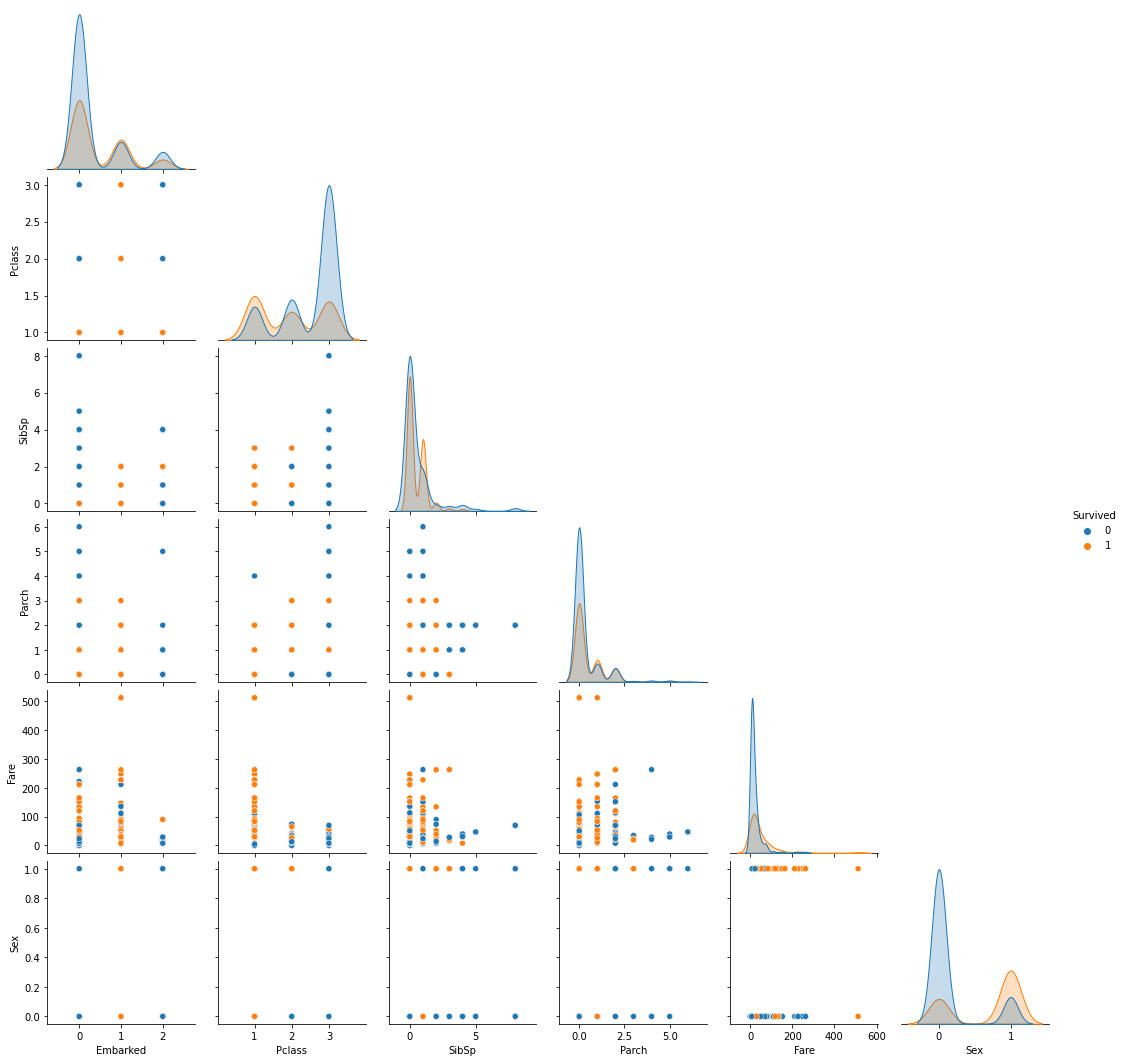

In [ ]:
sns.pairplot(hue="Survived", vars=["Embarked", "Pclass", "SibSp", "Parch", "Fare", "Sex"], data = df.toPandas() ,corner=True)

[Text(0.5, 1.0, 'Sex')]

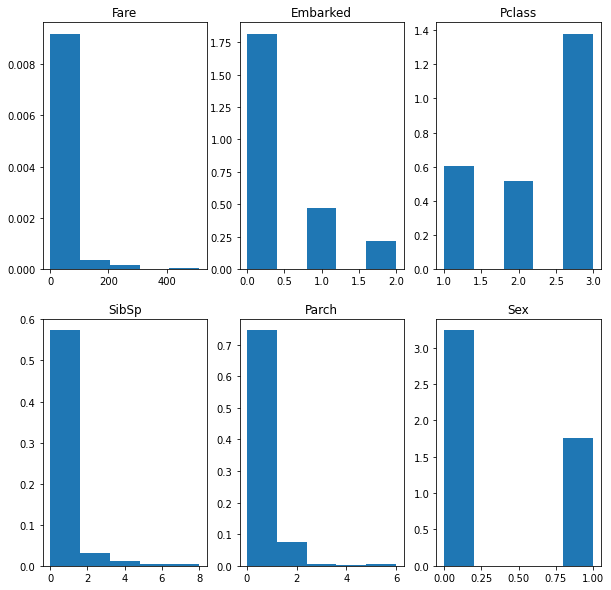

In [ ]:
fig, ax = plt.subplots(2, 3, figsize=(10, 10))
ax[0,0].hist("Fare", data=df.toPandas(), bins=5, density=0.5)
ax[0,0].set(title="Fare")
ax[0,1].hist("Embarked", data=df.toPandas(), bins=5, density=0.5)
ax[0,1].set(title="Embarked")
ax[0,2].hist("Pclass", data=df.toPandas(), bins=5, density=0.5)
ax[0,2].set(title="Pclass")
ax[1,0].hist("SibSp", data=df.toPandas(), bins=5, density=0.5)
ax[1,0].set(title="SibSp")
ax[1,1].hist("Parch", data=df.toPandas(), bins=5, density=0.5)
ax[1,1].set(title="Parch")
ax[1,2].hist("Sex", data=df.toPandas(), bins=5, density=0.5)
ax[1,2].set(title="Sex")

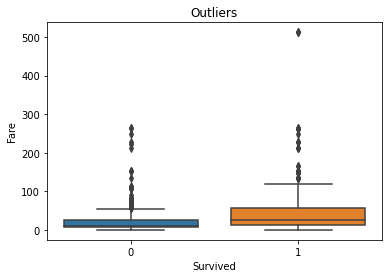

In [ ]:
plt.title("Outliers")
sns.boxplot(x="Survived", y="Fare", data=df.toPandas())

In [ ]:
print("The data contain %d records." % df.count())

The data contain 891 records.


# Modeling

In [ ]:
df.columns

['Survived', 'Pclass', 'SibSp', 'Parch', 'Fare', 'Embarked', 'Sex']

In [ ]:
assembler = VectorAssembler(inputCols=['Pclass', 'SibSp', 'Parch', 'Fare', 'Embarked', 'Sex'], outputCol="features")
df = assembler.transform(df)

df.select('features', 'Survived').show(10, truncate=False)

+-----------------------------+--------+
|features                     |Survived|
+-----------------------------+--------+
|[3.0,1.0,0.0,7.25,0.0,0.0]   |0       |
|[1.0,1.0,0.0,71.2833,1.0,1.0]|1       |
|[3.0,0.0,0.0,7.925,0.0,1.0]  |1       |
|[1.0,1.0,0.0,53.1,0.0,1.0]   |1       |
|(6,[0,3],[3.0,8.05])         |0       |
|[3.0,0.0,0.0,8.4583,2.0,0.0] |0       |
|(6,[0,3],[1.0,51.8625])      |0       |
|[3.0,3.0,1.0,21.075,0.0,0.0] |0       |
|[3.0,0.0,2.0,11.1333,0.0,1.0]|1       |
|[2.0,1.0,0.0,30.0708,1.0,1.0]|1       |
+-----------------------------+--------+
only showing top 10 rows



In [ ]:
training, testing = df.randomSplit([0.77, 0.23], seed=42)
ratio = training.count() / df.count()
print(ratio)

0.8035914702581369


### Logistic Regression with PySpark

In [ ]:
from pyspark.ml.classification import LogisticRegression

In [ ]:
lr = LogisticRegression(labelCol="Survived", featuresCol="features", regParam=0.1, elasticNetParam=1.0, maxIter=500)
model_lr = lr.fit(training)

prediction = model_lr.transform(testing)
prediction.select('Survived', 'prediction', 'probability').show(5, False)

+--------+----------+----------------------------------------+
|Survived|prediction|probability                             |
+--------+----------+----------------------------------------+
|0       |0.0       |[0.6602038440886607,0.33979615591133927]|
|0       |0.0       |[0.6602038440886607,0.33979615591133927]|
|0       |0.0       |[0.6602038440886607,0.33979615591133927]|
|0       |0.0       |[0.6602038440886607,0.33979615591133927]|
|0       |0.0       |[0.6602038440886607,0.33979615591133927]|
+--------+----------+----------------------------------------+
only showing top 5 rows



In [ ]:
# Create a confusion matrix
prediction.groupBy('Survived', 'prediction').count().show()

# Calculate the elements of the confusion matrix
TN = prediction.filter('prediction = 0 AND Survived = prediction').count()
TP = prediction.filter('prediction = 1 AND Survived = prediction').count()
FN = prediction.filter('prediction = 0 AND Survived != prediction').count()
FP = prediction.filter('prediction = 1 AND Survived != prediction').count()

# Accuracy measures the proportion of correct predictions
accuracy = (TN + TP) / (TN + TP + FN + FP)
print(accuracy)

+--------+----------+-----+
|Survived|prediction|count|
+--------+----------+-----+
|       1|       0.0|   21|
|       0|       0.0|   87|
|       1|       1.0|   50|
|       0|       1.0|   17|
+--------+----------+-----+

0.7828571428571428


In [ ]:
evaluator = MulticlassClassificationEvaluator(labelCol='Survived', metricName='accuracy')
evaluator.evaluate(prediction)

0.7828571428571428

In [ ]:
y_true = prediction.select("Survived").collect()
y_pred = prediction.select("prediction").collect()

print(classification_report(y_true, y_pred))
confusion_matrix(y_true, y_pred)

              precision    recall  f1-score   support

           0       0.81      0.84      0.82       104
           1       0.75      0.70      0.72        71

    accuracy                           0.78       175
   macro avg       0.78      0.77      0.77       175
weighted avg       0.78      0.78      0.78       175



array([[87, 17],
       [21, 50]])

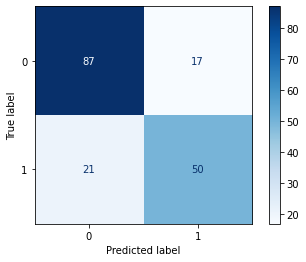

In [ ]:
display = ConfusionMatrixDisplay(confusion_matrix(y_true, y_pred), display_labels=[0,1])
display.plot(cmap=plt.cm.Blues)
plt.show()